In [ ]:
import random as rnd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import math as m
from sympy import *
from matplotlib import collections as mc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
from scipy.integrate import quad
from scipy.misc import derivative

x, y = symbols('x y')

Готово. Редактируемо

In [ ]:
# Цена доставки материалов
alpha = 0.1

# Функция поверхности
def beta(x, y):
    return 1 + np.sin(5*x) * np.sin(y)

# Параметры алгоритма
x0, y0 = 0, 0 # начало дороги
x1, y1 = 1, 1 # конец дороги
num_of_scouts = 450 # число разведчиков
num_of_foragers = 50 # число фуражиров
angle = m.radians(55 / 2) # длина дуги сектора, в котором ищется новая точка дороги
radius = (x1 - x0) / 9.5 # радиус сектора, в котором ищется новая позиция
rad_of_forage = (x1 - x0) / 100 # радиус доп. обследования фуражирами кандидата на новую позицию

Вспомогательная функция евклидова расстояния между двумя точками

In [ ]:
def dist(x1, y1, x2, y2):
  return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

Функция, задающая подсчет функционала между двумя точками

In [ ]:
def ifoc(x1, y1, x2, y2):
  if x2 < x1:
    x1, x2 = x2, x1
    y1, y2 = y2, y1
  len = dist(x1, y1, x2, y2)
  if x2 - x1 != 0:
    k = (y2 - y1) / (x2 - x1)
  else:
    k = 0
  x_range = np.linspace(x1, x2, 101).tolist()
  y_range = [k * x + y1 - k * x1 for x in x_range]
  sum = 0
  for i in range(100):
    sum += beta((x_range[i] + x_range[i + 1]) / 2, (y_range[i] + y_range[i + 1]) / 2)
  return (alpha / 2) * len**2 + (len / 100) * sum

Функция, описывающая сектор поиска на одной итерации. Возвращает информацию о том, находится ли точка (x_checked, y_checked) в секторе

In [ ]:
def sector(x_center, y_center, x_ch, y_ch):
  sine = m.sin(angle)
  cosine = m.cos(angle)
  r_x = x1 - x_center
  r_y = y1 - y_center
  if (x_ch - x_center) ** 2 + (y_ch - y_center) ** 2 <= radius ** 2 and \
  (x_ch - x_center) / (r_x * cosine - r_y * sine) >= (y_ch - y_center) / (r_y * cosine + r_x * sine) and \
  (x_ch - x_center) / (r_x * cosine + r_y * sine) <= (y_ch - y_center) / (r_y * cosine - r_x * sine) and \
  x0 <= x_ch <= x1 and y0 <= y_ch <= y1:
    return True
  else:
    return False

Распределение пчел-разведчиков по сектору

In [ ]:
def rand_cluster(x_center, y_center):
    flag = True
    while flag:
      theta = 2 * m.pi * rnd.random()
      s = radius * m.sqrt(rnd.random())
      dot_x, dot_y = x_center + s * m.cos(theta), y_center + s * m.sin(theta)
      new_dot_in_area = sector(x_center, y_center, dot_x, dot_y)
      if new_dot_in_area and new_dot_in_area != None:
        flag = False
    return [dot_x, dot_y]

Поиск локального оптимума в окрестности лучших точек

In [ ]:
def discover_area(x, y, x_h, y_h):
    global_epsilon = 0.000000001
    centre = (x, y)
    arr_shape = 100
    step = rad_of_forage / arr_shape

    def rotate_vector(length, a):
        return length * np.cos(a), length * np.sin(a)

    def derivative_x(epsilon, arg):
        return (beta(global_epsilon + epsilon, arg) - beta(epsilon, arg)) / global_epsilon

    def derivative_y(epsilon, arg):
        return (beta(arg, epsilon + global_epsilon) - beta(arg, epsilon)) / global_epsilon

    def calculate_flip_points():
        flip_points = np.array([0, 0])
        points = np.zeros((360, arr_shape), dtype=bool)
        cx, cy = centre
        for i in range(arr_shape):
            for alpha in range(360):
                x, y = rotate_vector(step, alpha)
                x = x * i + cx
                y = y * i + cy
                points[alpha][i] = derivative_x(x, y) + derivative_y(y, x) > 0
                if not points[alpha][i - 1] and points[alpha][i]:
                    flip_points = np.vstack((flip_points, np.array([alpha, i - 1])))
        return flip_points

    def pick_estimates(positions):
        vx, vy = rotate_vector(step, positions[1][0])
        cx, cy = centre
        best_x, best_y = cx + vx * positions[1][1], cy + vy * positions[1][1]
        for index in range(2, len(positions)):
            vx, vy = rotate_vector(step, positions[index][0])
            x, y = cx + vx * positions[index][1], cy + vy * positions[index][1]
            if ifoc(best_x, best_y, x_h, y_h) > ifoc(x, y, x_h, y_h):
                best_x = x
                best_y = y
        for index in range(360):
            vx, vy = rotate_vector(step, index)
            x, y = cx + vx * (arr_shape - 1), cy + vy * (arr_shape - 1)
            if ifoc(best_x, best_y, x_h, y_h) > ifoc(x, y, x_h, y_h):
                best_x = x
                best_y = y
        return best_x, best_y


    def gradient_descent(best_estimates, is_x):
        derivative = derivative_x if is_x else derivative_y
        best_x, best_y = best_estimates
        descent_step = step
        value = derivative(best_y, best_x)
        while abs(value) > global_epsilon:
            descent_step *= 0.95
            best_y = best_y - descent_step \
                if derivative(best_y, best_x) > 0 else best_y + descent_step
            value = derivative(best_y, best_x)
        return best_y, best_x

    def find_minimum():
        return gradient_descent(gradient_descent(pick_estimates(calculate_flip_points()), False), True)

    min_x, min_y = find_minimum()
    return [min_x, min_y]

Визуализация результатов.

In [ ]:
def drawing_the_result(center_x, center_y, bp_x, bp_y, iter):
  xx, yy = np.meshgrid(np.linspace(x0, x1, 100), np.linspace(x0, x1, 100))
  fig, ax = plt.subplots(1, 1, figsize=(4, 4))
  im = ax.contourf(xx, yy, beta(xx, yy), np.linspace(x0 - 0.1, x1 + 0.8, 1000), cmap="gray")
  ax.scatter([bp_x], [bp_y], marker='o', color='gold')
  plt.arrow(center_x, center_y, bp_x - center_x, bp_y - center_y, color='black')
  axins = inset_axes(ax,
                  width="7%",
                  height="100%",
                  loc='lower left',
                  bbox_to_anchor=(1.05, 0., 1, 1),
                  bbox_transform=ax.transAxes,
                  borderpad=0,
                  )
  plt.colorbar(im, cax=axins)
  plt.tight_layout()
  plt.show()


Основная часть.

<ipython-input-19-b9ea9557828d>:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


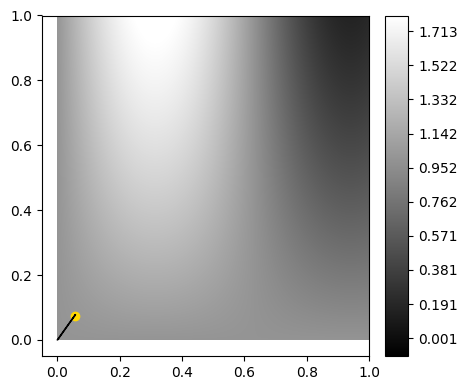

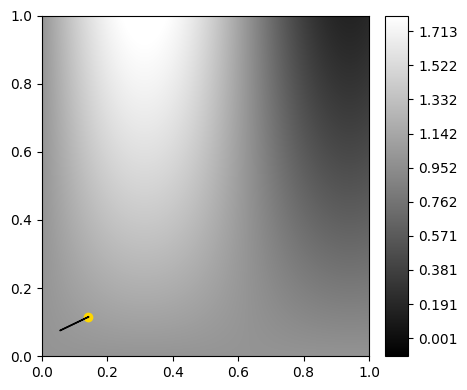

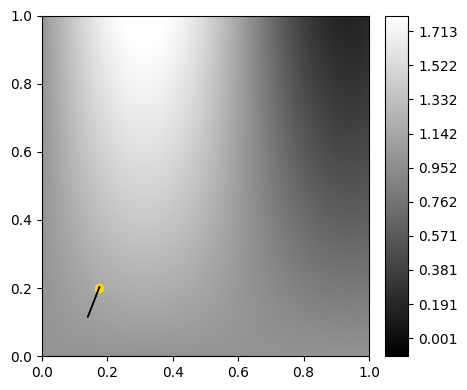

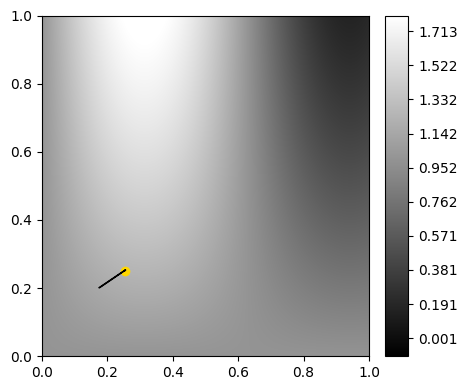

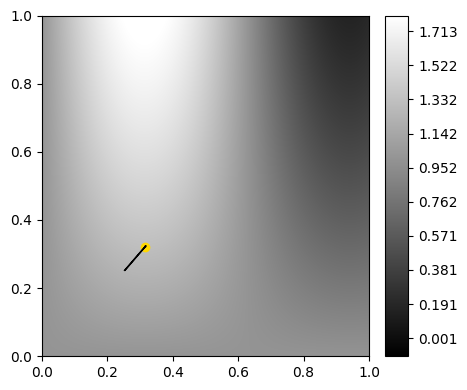

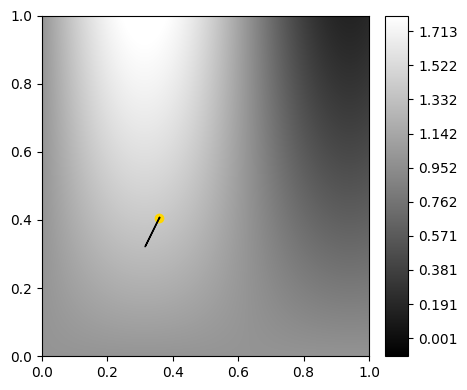

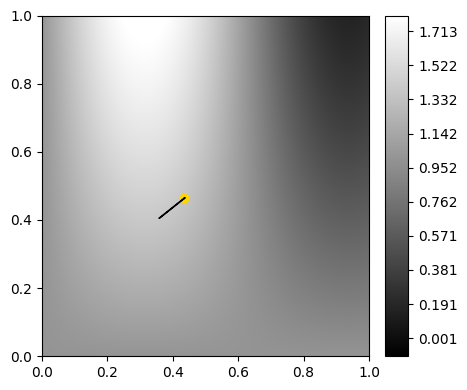

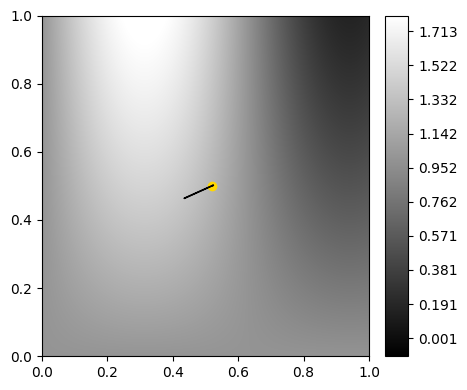

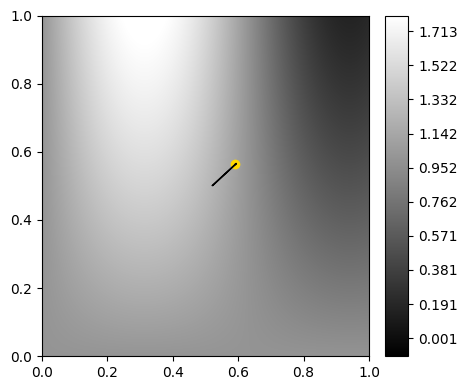

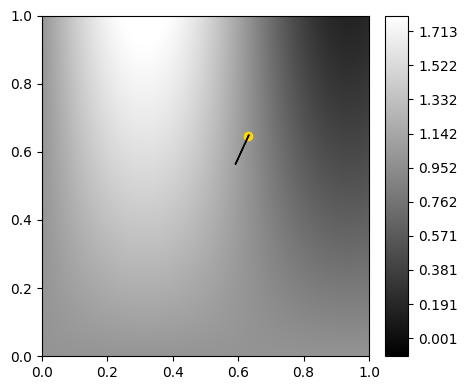

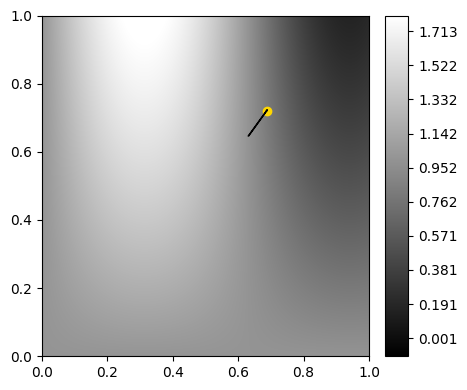

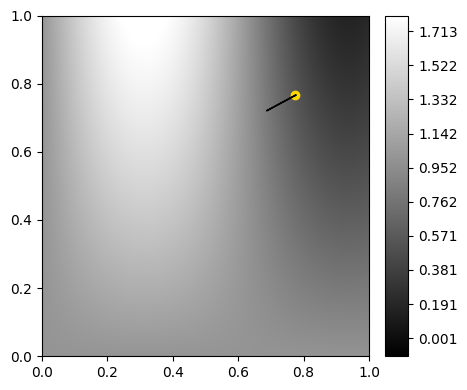

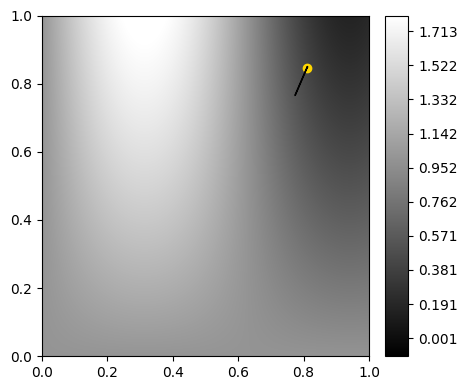

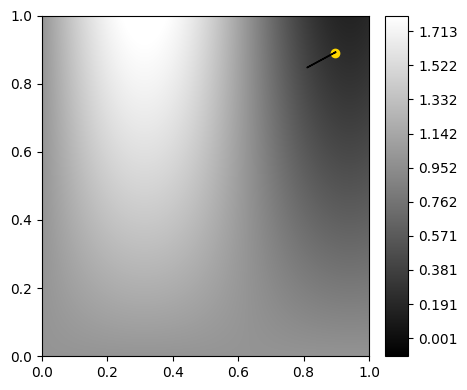

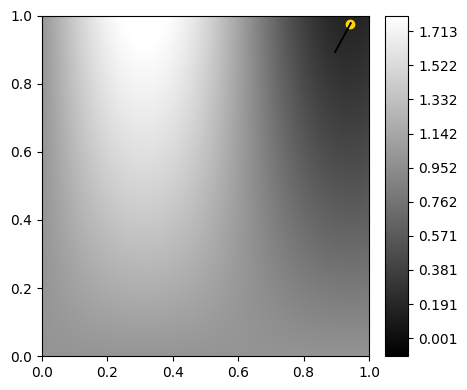

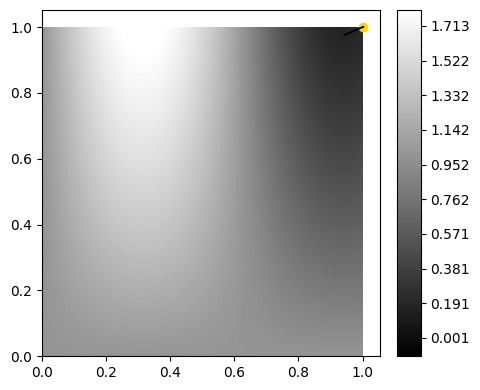

Число итераций: 16
Координаты ульев по абсциссе: [0, 0.05566029443633615, 0.14050574715172548, 0.17541706995165973, 0.2532974574838647, 0.31603386516850984, 0.3587719427742356, 0.43503078822830554, 0.5214239089201204, 0.591778686176562, 0.6315341481485613, 0.6870864722734217, 0.7740265238417056, 0.8106473556779091, 0.8955224775242354, 0.9430437080418932, 1]
Координаты ульев по ординате: [0, 0.0753483569523852, 0.11454435294197671, 0.20088101453298762, 0.25161639722327267, 0.3216440358849775, 0.4048283113638285, 0.46324244961408906, 0.5007135248250844, 0.5631946578055306, 0.6462568034443602, 0.7202955391676962, 0.765311372352145, 0.84704274531202, 0.8911287982715578, 0.9754333155743824, 1]
Стоимость пути: 1.3648458779648753


In [ ]:
def bee_algo():
  x_hives, y_hives = [x0], [y0]
  x_h, y_h = x0, y0
  num_of_iter = 0
  cost_of_road = 0
  while x_h != x1 and y_h != y1:
    if dist(x1, y1, x_h, y_h) <= radius:
      drawing_the_result(x_h, y_h, x1, y1, num_of_iter)
      x_h, y_h = x1, y1
      x_hives.append(x1)
      y_hives.append(y1)
      num_of_iter += 1
      cost_of_road += ifoc(x_h, y_h, x1, y1)
    else:
      honey_places = []
      for i in range(num_of_scouts):
        honey_places.append(rand_cluster(x_h, y_h))
      for i in range(len(honey_places)):
        honey_places[i].append(ifoc(honey_places[i][0], honey_places[i][1], x_h, y_h))
      hives_x = [honey_places[i][0] for i in range(num_of_scouts)]
      hives_y = [honey_places[i][1] for i in range(num_of_scouts)]
      best_points = sorted(honey_places, key=lambda x: x[2], reverse=True)[:num_of_foragers]
      best_points_x = [best_points[i][0] for i in range(num_of_foragers)]
      best_points_y = [best_points[i][1] for i in range(num_of_foragers)]
      new_places = []
      #for item in best_points:
      #  new_places.append(discover_area(item[0], item[1], x_h, y_h))
      best_point_ever = min(best_points, key= lambda item: ifoc(item[0], item[1], x_h, y_h))
      num_of_iter += 1
      drawing_the_result(x_h, y_h, best_point_ever[0], best_point_ever[1], num_of_iter)
      cost_of_road += ifoc(x_h, y_h, best_point_ever[0], best_point_ever[1])
      x_h, y_h = best_point_ever[0], best_point_ever[1]
      x_hives.append(x_h)
      y_hives.append(y_h)

  print(f"Число итераций: {num_of_iter}")
  print(f"Координаты ульев по абсциссе: {x_hives}")
  print(f"Координаты ульев по ординате: {y_hives}")
  print(f"Стоимость пути: {cost_of_road}")
  return x_hives, y_hives, num_of_iter, cost_of_road

interp_x, interp_y, num_of_hives, cost_of_road = bee_algo()

In [ ]:
# Метод неопределённых коэффициентов
x = Symbol('x', real=True)
right_part = np.array(interp_y)
matrix = []
for i in range(len(interp_x)):
  line = []
  for j in range(len(interp_x)):
    line.append(float('{:.5f}'.format(interp_x[i]**j)))
  matrix.append(line)
coeff = np.linalg.solve(np.array(matrix), right_part).tolist()
equation = 0
for i in range(len(interp_x)):
  equation += float('{:.4f}'.format(coeff[i]))*x**i
print(equation)

36243.4885*x**16 - 117541.208*x**15 + 96284.9783*x**14 + 25872.3416*x**13 - 7795.8559*x**12 - 79440.408*x**11 + 45849.4012*x**10 - 16368.1252*x**9 + 38605.359*x**8 - 13039.399*x**7 - 23913.441*x**6 + 20619.1087*x**5 - 6028.6862*x**4 + 672.2536*x**3 - 20.323*x**2 + 1.5155*x


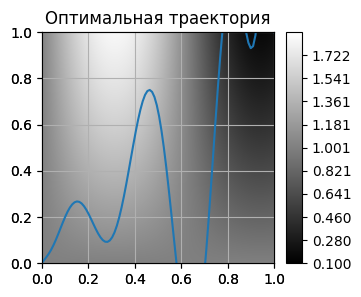

In [ ]:
def drawing_the_line(func):
  xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  xg = np.linspace(0, 1, 100)
  fig, ax = plt.subplots()
  fig.set_figwidth(3)
  fig.set_figheight(3)
  ax = fig.add_subplot()
  ax.set_title(f"Оптимальная траектория")
  ax.grid()
  plt.axis([0, 1, 0, 1])
  yg = [func.subs(x, i) for i in xg]
  plt.plot(xg, yg)
  im = ax.contourf(xx, yy, beta(xx, yy), np.linspace(0.1, 1.9, 1000), cmap="gray")
  #ax.scatter(interp_x, interp_y, marker=".", color='gold')
  axins = inset_axes(ax,
                  width="7%",
                  height="100%",
                  loc='lower left',
                  bbox_to_anchor=(1.05, 0., 1, 1),
                  bbox_transform=ax.transAxes,
                  borderpad=0,
                  )
  plt.colorbar(im, cax=axins)
  plt.show()

drawing_the_line(equation)